# Problem Overview

This challenge is hosted by WiDS Datathon Committee. It focuses on patient health, with an emphasis on the chronic condition of diabetes, through data from MIT’s GOSSIS (Global Open Source Severity of Illness Score) initiative.

**Background**

Getting a rapid understanding of the context of a patient’s overall health has been particularly important during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system. Knowledge about chronic conditions such as diabetes can inform clinical decisions about patient care and ultimately improve patient outcomes.

**Overview**

In this challenge, participants are required to build a model to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus.

**Data Files**

**TrainingWiDS2021.csv** - the training data. You should see 130,157 encounters represented here. Please view the Data Dictionary file for more information about the columns.

**UnlabeledWiDS2021.csv** - the unlabeled data (data without diabetes_mellitus provided). You are being asked to predict the diabetes_mellitus variable for these encounters.

**SampleSubmissionWiDS2021.csv** - a sample submission file in the correct format.

**SolutionTemplateWiDS2021.csv** - a list of all the rows (and encounters) that should be in your submissions.****

**DataDictionaryWiDS2021.csv** - supplemental information about the data.

**Evaluation metric**

Model will be evaluated on ethe Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

**Install dabl which stands for Data Analysis Baseline library. Dabl can be used to automate many of the tasks related to data exploration and analysis**

# Import Libraries

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

import dabl

#from pandas_profiling import ProfileReport #For generating profile reports

import matplotlib.pyplot as plt  #data visualization
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from sklearn.experimental import enable_iterative_imputer   # For imputing missing values
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix  #metrics
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')  #silence warnings

### CONSTANTS

In [2]:
CAT_COLUMNS = {
    "demographic1" : ['age', 'gender', 'ethnicity', 'weight', 'height', 'bmi'], 
    "demographic2" : ['elective_surgery', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type','icu_type',           
    'pre_icu_los_days'], 
    "apache_covariate" : ['albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache',
       'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache',
       'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache'],
    "apache_comorbidity" : ['aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'diabetes_mellitus'
       ],
    "vitals_d1" : ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max',
       'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
       'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min',
       'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min'],
    "vitals_h1" : ['h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max',
       'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
       'h1_temp_max', 'h1_temp_min'],
    "labs_d1" :['d1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
       'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
       'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min'],
    "labs_h1" : ['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
       'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max',
       'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min',
       'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min',
       'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max',
       'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max',
       'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min',
       'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max',
       'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min'], 
    "labs_blood_gas" : ['d1_arterial_pco2_max',
       'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min',
       'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max',
       'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min',
       'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max',
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']
}

CAT_COLORS = {  'demographic1':  '#812878',                             
                'demographic2':  '#B0B3D6',
                'apache_covariate': '#2C2255',
                'apache_comorbidity': '#4B8BBE',
                'vitals_d1':  '#CC2336', 
                'vitals_h1': '#FFE873',
                'labs_d1': '#E4682A', 
                'labs_h1': '#FFD43B', 
                'labs_blood_gas': '#F69824'
                }

### COMMON FUNCTIONS

In [3]:
def getColor(col):
    for cat in CAT_COLUMNS.keys():
        if col in CAT_COLUMNS[cat]: 
            return CAT_COLORS.get(cat, '#333333')

def missingData(df):
    print(df.shape)
    missing_cnt = df.isna().sum() #column wise sum of missing values

    #display only the columns with missing values with count and proportion of missing values by column 
    missing_df = pd.concat([missing_cnt.rename('Missing Count'), 
                            missing_cnt.div(len(df)/100).rename('Missing Ratio')], axis=1).loc[missing_cnt.ne(0)]
    missing_df = missing_df.reset_index().rename(columns={'index': 'Feature'})
    missing_df['Filled Ratio'] = missing_df['Missing Ratio'].apply(lambda x: 100-x)
    print(missing_df)
    COLORS=[getColor(col) for col in missing_df['Feature'].values]
    print(missing_df.columns)
    #print(COLORS)
    missing_df.plot.bar(x='Feature', y='Filled Ratio', title="Filled data", figsize=(18,6), fontsize=7, color=COLORS)
    return missing_df

In [70]:
def printDFDetails(df):
    print(f"Shape: {df.shape}; Null values: {pd.DataFrame(df).isna().sum().sum()}\nColumns: {df.columns} \nColumns of object type: {df.select_dtypes('object').columns}")

In [4]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

    def inverse_transform(self, data_list):
        return self.label_encoder.inverse_transform(data_list)

def labelEncode(df, col):
    df[col] = df[col].fillna(np.nan) 
    df_original = df[col]
    df_mask = df[col].isnull()

    #df[col] = df[[col]].apply(LabelEncoder().fit_transform)
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

    df[col] = df[col].where(~df_mask, df_original)
    #print(df[col])
    return df, le

In [5]:
encoders = {}

# impute string values using SimpleImputer with 'most_frequent' strategy
def imputeSimple(df_train, df_unlabeled, cols):
    simple_imp = SimpleImputer(strategy='most_frequent')

    print("Column unique values: ", end=" ")
    [print(col, df_train[col].unique(), end=" ") for col in cols]; print()
    for col in cols:
        le1 = LabelEncoder()
        le = LabelEncoderExt()
        
        le.fit(df_train[col])
        print('le.classes_:', le.classes_)
        encoders[col] = le

        # fill missing values with np.nan
        df_train[col] = df_train[col].fillna(np.nan) 
        df_unlabeled[col] = df_unlabeled[col].fillna(np.nan) 
       
        simple_imp.fit(df_train[col].values.reshape(-1,1))

        df_train[col] = simple_imp.transform(df_train[col].values.reshape(-1,1))
        df_train[col] = df_train[col].astype('str') # convert data to string type
        df_train[col] = le.transform(df_train[col])

        df_unlabeled[col] = simple_imp.transform(df_unlabeled[col].values.reshape(-1,1))
        df_unlabeled[col] = df_unlabeled[col].astype('str')
        df_unlabeled[col] = le.transform(df_unlabeled[col])
    [print(df_train[col].unique(), end=" ") for col in cols]; print()
    return df_train, df_unlabeled

# Impute numerical values
def imputeIterative(df_train, df_unlabeled, unlabeled=False):
    tic = datetime.now()
    iter_imp = IterativeImputer(random_state=0) # instantiate IterativeImputer

    iter_imp.fit(df_train) # fit and transform the data
    
    df_train_new = iter_imp.fit_transform(df_train) # fit and transform the data
    df_train_new = pd.DataFrame(df_train_new, columns=df_train.columns)

    df_unlabeled_new = pd.DataFrame()
    if unlabeled == True:
        df_unlabeled_new = iter_imp.fit_transform(df_unlabeled) # fit and transform the data
        df_unlabeled_new = pd.DataFrame(df_unlabeled_new, columns=df_unlabeled.columns)

    toc = datetime.now()
    print(f"IterativeImputer took {toc-tic}sec")
    return df_train_new, df_unlabeled_new

xgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters 

'''
Computes roc auc score as the score will computed for several datasets. 
- It will split the training set into a sub training set (80%) and test set(20%). 
- A simple XGBClassifier will be trained on the sub training set, evaluated on test set.
- Finally the function prints roc auc score on full training set and the original test set.
'''
def compute_roc_auc(train_test_split, train_set, target):
    tic = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(train_set, target, test_size=0.2, random_state=42)
    xgb.fit(X_train, y_train)
    y_test_pred = xgb.predict(X_test)
    y_train_pred = xgb.predict(X_train)
    print('train auc',roc_auc_score(y_train, y_train_pred))
    print('test auc',roc_auc_score(y_test, y_test_pred)) 
    toc = datetime.now()
    print("Time taken:", toc-tic)  

def add_features(lower_limit, upper_limit, df, missing_df, df_to_merge):
    df_ = df[missing_df[(missing_df['Missing Ratio']>=lower_limit) & (missing_df['Missing Ratio']<upper_limit)].index]
    df_new = pd.concat([pd.DataFrame(df_to_merge), df_], axis=1) # concatenate new table with existing table
    df_new = df_new.select_dtypes(include=['int', 'float']) # exclude columns with string datatype, if any
    df_new_ = imputeIterative(df_new,pd.DataFrame()) #iter_imp.fit_transform(df_new)
    df_new_ = pd.DataFrame(df_new_, columns=df_new.columns) # return table with column names intact
    return df_new_

# Load data

In [6]:
df = pd.read_csv("data/TrainingWiDS2021.csv")
test = pd.read_csv("data/UnlabeledWiDS2021.csv")

# Exploratory Data Analysis

In [7]:
df.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [8]:
test.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [9]:
print(df.shape)
print(test.shape)

(130157, 181)
(10234, 180)


In [10]:
df.describe() # summary statistics for numeric features

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,130157.000000,130157.000000,130157.000000,125169.000000,125667.000000,130157.000000,128080.000000,130157.000000,130157.000000,130157.0,...,16760.000000,16760.000000,130157.00000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000
mean,65079.000000,213000.856519,106.102131,61.995103,29.110260,0.189840,169.607219,662.428344,0.839933,0.0,...,247.525419,239.617358,0.00103,0.016081,0.013599,0.025669,0.007307,0.004187,0.020852,0.216285
std,37573.233831,38109.828146,63.482277,16.822880,8.262776,0.392176,10.833085,304.259843,2.485337,0.0,...,131.440167,128.562211,0.03207,0.125786,0.115819,0.158146,0.085166,0.064574,0.142888,0.411712
min,1.000000,147000.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.250000,0.0,...,42.000000,38.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32540.000000,180001.000000,49.000000,52.000000,23.598006,0.000000,162.500000,427.000000,0.045833,0.0,...,144.000000,138.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65079.000000,213014.000000,112.000000,64.000000,27.564749,0.000000,170.100000,653.000000,0.155556,0.0,...,228.125000,218.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97618.000000,246002.000000,165.000000,75.000000,32.803127,0.000000,177.800000,969.000000,0.423611,0.0,...,333.000000,324.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,130157.000000,279000.000000,204.000000,89.000000,67.814990,1.000000,195.590000,1111.000000,175.627778,0.0,...,720.000000,654.813793,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Drop columns with all unique values or same value

In [11]:
df.drop(['Unnamed: 0', 'encounter_id', 'hospital_id', 'icu_id', 'readmission_status'], axis=1, inplace=True) #drop columns with all unique values
test_ids = test.pop('encounter_id')  # ids required for submission
test.drop(['Unnamed: 0'], axis=1, inplace=True) 

target = df['diabetes_mellitus']

# Missing values

The data size is quite large, it has 130157 X 181 values. Let's see how many columns have missing values in terms of percentage.

(130157, 176)
                  Feature  Missing Count  Missing Ratio  Filled Ratio
0                     age           4988       3.832295     96.167705
1                     bmi           4490       3.449680     96.550320
2               ethnicity           1587       1.219297     98.780703
3                  gender             66       0.050708     99.949292
4                  height           2077       1.595765     98.404235
..                    ...            ...            ...           ...
155    h1_arterial_ph_min         107849      82.860699     17.139301
156   h1_arterial_po2_max         107445      82.550305     17.449695
157   h1_arterial_po2_min         107445      82.550305     17.449695
158  h1_pao2fio2ratio_max         113397      87.123243     12.876757
159  h1_pao2fio2ratio_min         113397      87.123243     12.876757

[160 rows x 4 columns]
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


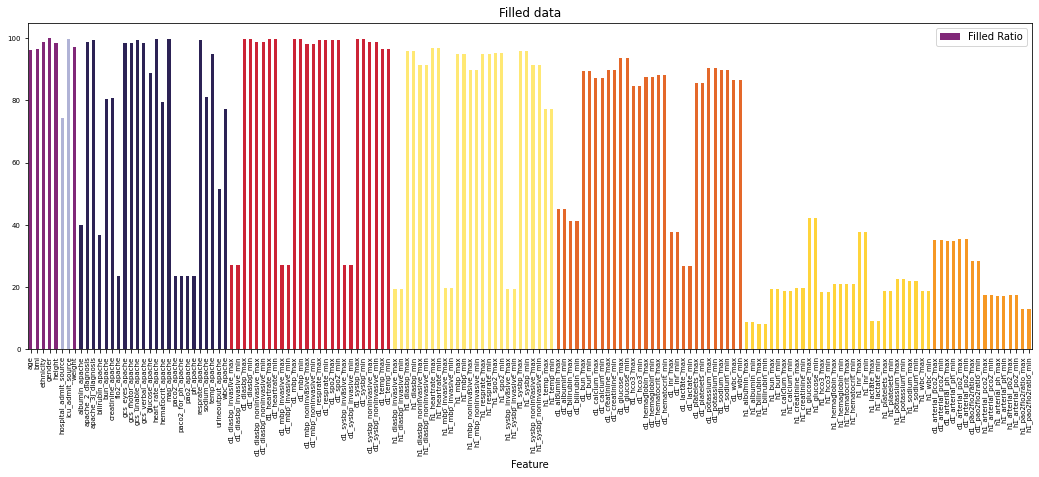

In [12]:
'''missing_cnt = df.isna().sum() #column wise sum of missing values

#display only the columns with missing values with count and proportion of missing values by column 
missing_df = pd.concat([missing_cnt.rename('Missing Count'), 
                        missing_cnt.div(len(df)/100).rename('Missing Ratio')], axis=1).loc[missing_cnt.ne(0)]
missing_df'''
missing_df = missingData(df)

Out of 181 columns, 160 have missing values. The proportion of missing values in some columns is more than 80%. Clearly, missing values is a major issue with this data which needs to be fixed.

# Addressing null values

The data has 160 columns with null values in varying proportions. However, it is important to retain as many features as possible for building a good predictive model. In order to minimize loss of data or introduction of arbitrary values, I will use sklearn's iterative imputer to impute missing values based on existing non-null features. I will do this in a phased manner as mentioned below.
* Start with only non-null features, train model on these features, evaluate roc-auc score on test data
* Add features with less than 5% missing values to initial non-null data, impute missing values using iterative imputer, train model and evaluate roc-auc score on test data
* Add features with missing values between 5% - 10% to latest data (result of previous step), impute missing values, train model and evaluate
* Add features with additional 5% missing data to existing data at each stage, impute, train and evaluate. Repeat these steps until there is no further improvement in roc-auc score of test data. At this point it is probable that a lot of data has been added through imputation and adding further data doesn't help the model learn relationships between the independent variables and the dependent variable

All features are required to be of int or float datatype for the purpose of imputing or modeling. Hence, convert icu_stay_type and icu_type from string to int dytpe. LabelEncoder is a useful method for this purpose, however in this case there are some new labels in test set which are not present in train set. So if we try to fit the encoder on train set and use it to transform the test set using sklearn's LabelEncoder class, we will see a value error. To overcome this issue, I'm defining a new label encoder class that will append a new label 'Unknown' to the existing labels at the time of fitting. When the encoder encounters a previously unseen value, it simply assigns the Unknown label to it.

## df_non_null: only non-null features

In [13]:
df_non_null = df.dropna(axis=1) #drop all columns with missing values
df_non_null.drop('diabetes_mellitus', axis=1, inplace=True)

In [14]:
printDFDetails(df_non_null)

(130157, 15) 0 Index(['icu_stay_type', 'icu_type'], dtype='object')


In [16]:
'''
le = LabelEncoderExt()  
le.fit(df_non_null['icu_stay_type']) #fit on train set column 
df_non_null['icu_stay_type'] = le.transform(df_non_null['icu_stay_type']) #transform train set column 
test['icu_stay_type'] = le.transform(test['icu_stay_type']) #transform test set column

le.fit(df_non_null['icu_type'])
df_non_null['icu_type'] = le.transform(df_non_null['icu_type'])
test['icu_type'] = le.transform(test['icu_type'])
'''

"\nle = LabelEncoderExt()  \nle.fit(df_non_null['icu_stay_type']) #fit on train set column \ndf_non_null['icu_stay_type'] = le.transform(df_non_null['icu_stay_type']) #transform train set column \ntest['icu_stay_type'] = le.transform(test['icu_stay_type']) #transform test set column\n\nle.fit(df_non_null['icu_type'])\ndf_non_null['icu_type'] = le.transform(df_non_null['icu_type'])\ntest['icu_type'] = le.transform(test['icu_type'])\n"

In [17]:
df_non_null.groupby(by='icu_stay_type')['icu_stay_type'].agg(['count'])

,count
icu_stay_type,
admit,124741
readmit,615
transfer,4801


In [18]:
df_non_null = pd.get_dummies(df_non_null, prefix = ['icu_stay_type','icu_type'], drop_first=True)

In [19]:
df_non_null.columns

Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU'],
      dtype='object')

In [20]:
print(df_non_null.shape, pd.DataFrame(df_non_null).isna().sum().sum(), df_non_null.select_dtypes('object').columns) # columns with object

(130157, 22) 0 Index([], dtype='object')


In [21]:
compute_roc_auc(train_test_split, df_non_null, target)

[17:42:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train auc 0.5158736169254257
test auc 0.5099616865829137
Time taken: 0:00:10.658987


## df_5: Select columns which have missing data <= 5% 
**Imputation strategy:**
- Categorical variables: Simple Imputer (most-frequent)
- Continuous variables: Iterative Imputer

In [22]:
cols_5 = missing_df[missing_df['Missing Ratio']<5]['Feature'] # get names of columns with less than 5% missing values
#cols_5.extend(['hospital_id', 'icu_id', 'readmission_status']) # get id and constant value colums
df_5 = pd.concat([df_non_null, df[cols_5]], axis=1) # concatenate new table with existing non-null values table
printDFDetails(df_5)

(130157, 68) 108575 Index(['ethnicity', 'gender', 'icu_admit_source'], dtype='object')


In [24]:
df_5, test = imputeSimple(df_5, test, ['ethnicity','gender','icu_admit_source'])

Column unique values:  ethnicity ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown'] gender ['M' 'F' nan] icu_admit_source ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan] 
le.classes_: ['African American' 'Asian' 'Caucasian' 'Hispanic' 'Native American'
 'Other/Unknown' 'Unknown' 'nan']
le.classes_: ['F' 'M' 'Unknown' 'nan']
le.classes_: ['Accident & Emergency' 'Floor' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' 'Unknown' 'nan']
[2 3 0 1 4 5] [1 0] [1 0 2 3 4] 


In [25]:
print(encoders.keys())
print(encoders['ethnicity'].classes_)
print(len(df_5.columns), df_5.columns)
print(df_5[['ethnicity']].groupby(by='ethnicity')['ethnicity'].agg(['count']))
for col in ['ethnicity','gender','icu_admit_source']:
    df_5[[col]] = encoders[col].inverse_transform(df_5[[col]])
    print(df_5[col].unique())
    print(df_5[[col]].groupby(by=col)[col].agg(['count']))


dict_keys(['ethnicity', 'gender', 'icu_admit_source'])
['African American' 'Asian' 'Caucasian' 'Hispanic' 'Native American'
 'Other/Unknown' 'Unknown' 'nan']
68 Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU', 'age', 'bmi', 'ethnicity',
       'gender', 'height', 'icu_admit_source', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache',
       'map_apache', 'resprate_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_dia

In [26]:
df_5.isna().sum()

elective_surgery            0
pre_icu_los_days            0
apache_post_operative       0
arf_apache                  0
intubated_apache            0
                         ... 
h1_resprate_min          6454
h1_spo2_max              6242
h1_spo2_min              6242
h1_sysbp_max             5519
h1_sysbp_min             5519
Length: 68, dtype: int64

In [27]:
df_5.columns

Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU', 'age', 'bmi', 'ethnicity',
       'gender', 'height', 'icu_admit_source', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache',
       'map_apache', 'resprate_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_r

In [28]:
df_5 = pd.get_dummies(df_5, prefix = ['ethnicity','gender','icu_admit_source'], drop_first=True)

In [29]:
df_5.columns

Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU', 'age', 'bmi', 'height', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'heart_rate_apache', 'map_apache', 'resprate_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1

In [30]:
compute_roc_auc(train_test_split, df_5, target)

[17:43:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train auc 0.7100539691440749
test auc 0.5866983496774899
Time taken: 0:00:44.004065


## df_5_knn: Select columns which have missing data <= 5% 
**Imputation strategy:**
- Categorical variables: KNN Imputer
- Continuous variables: Iterative Imputer

In [31]:
cols_5 = missing_df[missing_df['Missing Ratio']<5]['Feature'] # get names of columns with less than 5% missing values
print("df_non_null.columns", len(df_non_null.columns), df_non_null.columns)
print("df[cols_5].columns", len(df[cols_5].columns), df[cols_5].columns)
df_5_knn = pd.concat([df_non_null, df[cols_5]], axis=1) # concatenate new table with existing non-null values table
print(df_5_knn.shape, pd.DataFrame(df_5_knn).isna().sum().sum(), df_5_knn.select_dtypes('object').columns)

encoders_knn = {}
for col in ['ethnicity', 'gender', 'icu_admit_source']:
    print("Before LE:", df_5_knn[col].unique())
    
    df_5_knn, le = labelEncode(df_5_knn, col)
    encoders_knn[col] = le
    print("After LE:", type(df_5_knn), df_5_knn[col].unique())
    
    #df_5_knn[col] = imputer.fit_transform(df_5_knn[col].values.reshape(-1,1))
    #print("After impute:", df_5_knn[col].unique())
    print()

data = df_5_knn.values
ix = [i for i in range(data.shape[1])]
X = data[:, ix]

df_non_null.columns 22 Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU'],
      dtype='object')
df[cols_5].columns 46 Index(['age', 'bmi', 'ethnicity', 'gender', 'height', 'icu_admit_source',
       'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'heart_rate_apache', 'map_apache',
       'resprate_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1

In [32]:
X.shape

(130157, 68)

In [33]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
tic = datetime.now()
np_5_knn = knn_imputer.fit_transform(X)
toc = datetime.now()
print(f"KNN Imputer {toc-tic} sec")

KNN Imputer 14:43:44.831193 sec


In [34]:
#df_5_knn[col] = pd.DataFrame(df_5_knn, columns=df_5.columns)
cols = df_non_null.columns.tolist()
print(type(cols), cols)
cols.extend(cols_5)
df_5_knn = pd.DataFrame(np_5_knn, columns = cols)
print(df_5_knn.shape, df_5_knn.isna().sum().sum(), df_5_knn.select_dtypes('object').columns, df_5_knn.columns)

<class 'list'> ['elective_surgery', 'pre_icu_los_days', 'apache_post_operative', 'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit', 'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU', 'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU', 'icu_type_SICU']
(130157, 68) 0 Index([], dtype='object') Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU', 'age', 'bmi', 'ethnicity',
       'gen

In [50]:
for col in ['ethnicity', 'gender', 'icu_admit_source']:
    df_5_knn[col] = df_5_knn[col].astype(int)

In [53]:
df_5_knn[['gender', 'ethnicity', 'icu_admit_source']][0:10]

,gender,ethnicity,icu_admit_source
0,1,2,1
1,0,2,1
2,0,2,0
3,0,2,2
4,1,2,0
5,1,2,0
6,0,2,0
7,1,2,0
8,1,2,3
9,1,2,0


In [54]:
type(df_5_knn)

pandas.core.frame.DataFrame

In [68]:
df_5_knn.groupby(by='ethnicity')['ethnicity'].agg(['count'])

,count
ethnicity,
African American,14162
Asian,3244
Caucasian,100475
Hispanic,5049
Native American,966
Other/Unknown,6261


In [55]:
for col in ['ethnicity', 'gender', 'icu_admit_source']:
    print(type(encoders_knn[col]))
    df_5_knn[[col]] = encoders_knn[col].inverse_transform(df_5_knn[[col]])

<class 'sklearn.preprocessing._label.LabelEncoder'>
<class 'sklearn.preprocessing._label.LabelEncoder'>
<class 'sklearn.preprocessing._label.LabelEncoder'>


In [63]:
df_5_knn[['ethnicity', 'gender', 'icu_admit_source']][0:10]

,ethnicity,gender,icu_admit_source
0,Caucasian,M,Floor
1,Caucasian,F,Floor
2,Caucasian,F,Accident & Emergency
3,Caucasian,F,Operating Room / Recovery
4,Caucasian,M,Accident & Emergency
5,Caucasian,M,Accident & Emergency
6,Caucasian,F,Accident & Emergency
7,Caucasian,M,Accident & Emergency
8,Caucasian,M,Other Hospital
9,Caucasian,M,Accident & Emergency


In [64]:
df_5_knn_new = pd.get_dummies(df_5_knn, prefix = ['ethnicity', 'gender', 'icu_admit_source'], drop_first=True)

In [69]:
print(len(df_5_knn_new.columns), df_5_knn_new.columns)

75 Index(['elective_surgery', 'pre_icu_los_days', 'apache_post_operative',
       'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids',
       'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'icu_stay_type_readmit',
       'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU',
       'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
       'icu_type_Neuro ICU', 'icu_type_SICU', 'age', 'bmi', 'height', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'heart_rate_apache', 'map_apache', 'resprate_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       

In [66]:
df_5_knn_new[0:10]

,elective_surgery,pre_icu_los_days,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,hepatic_failure,immunosuppression,...,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,1,0,0,0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,1,0,0,0,1,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [67]:
compute_roc_auc(train_test_split, df_5_knn_new, target)

[09:29:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train auc 0.6919664559683606
test auc 0.5817057830741308
Time taken: 0:00:28.358269


## df_10: Select columns which have missing data <= 10% 
- Categorical variables: Simple impute
- Numerical variables: Itertive impute

In [ ]:
lower_limit = 5; upper_limit=10

In [ ]:
df_ = df[missing_df[(missing_df['Missing Ratio']>=lower_limit) & (missing_df['Missing Ratio']<upper_limit)]['Feature']]
df_10 = pd.concat([pd.DataFrame(df_5), df_], axis=1) # concatenate new table with existing table
df_10 = df_10.select_dtypes(include=['int', 'float']) # exclude columns with string datatype, if any

In [ ]:
print(type(df_10), df_10.shape, df_10.columns)

In [ ]:
df_10, _ = imputeIterative(df_10, pd.DataFrame()) #iter_imp.fit_transform(df_new)


In [ ]:
print(type(df_10))

In [ ]:
df_10 = pd.DataFrame(df_10, columns=df_10.columns) # return table with column names intact

In [ ]:
compute_roc_auc(train_test_split, df_10, target)


In [ ]:
test_pred = xgb.predict(test_df)
test_pred

# Submission

In [ ]:
my_submission = pd.DataFrame()
my_submission['encounter_id'] = test_ids
my_submission['diabetes_mellitus'] = test_pred
my_submission.to_csv('My_submission.csv', index=False)

First submission yielded auc score of 0.7048 on Kaggle Public Leaderbard which is quite close to the auc score on my internal test set.